In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri


In [2]:
from scipy.io import mmread
from scipy.sparse import csr_matrix

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
anndata2ri                  1.1
anyio                       NA
appnope                     0.1.3
arrow                       1.2.3
asttokens                   NA
attr                        21.2.0
babel                       2.12.1
backcall                    0.2.0
certifi                     2022.12.07
cffi                        1.15.1
charset_normalizer          3.1.0
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.6
decorator                   5.1.1
defusedxml                  0.7.1
executing                   1.2.0
fastjsonschema              NA
fqdn                        NA
gprofiler                   1.0.0
h5py                        3.8.0
idna                        3.4
igraph                      0.10.4
importlib_resources         NA
ipykernel                   6.22.0
ipython_gen

In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

载入需要的程辑包：SingleCellExperiment
载入需要的程辑包：SummarizedExperiment
载入需要的程辑包：MatrixGenerics
载入需要的程辑包：matrixStats

载入程辑包：‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, ro

In [5]:
# 1. Reading the data

In [6]:
# Data loading

# Files
sample_strings = ["Duo_M1","Duo_M2","Jej_M1","Jej_M2","Il_M1","Il_M2"]
sample_id_strings = ["3","4","5","6","7","8"]
file_base = "./GSE92332_RAW/GSM283657"
exp_string = "_Regional_"
data_end = "_matrix.mtx.gz"
barcode_end = "_barcodes.tsv.gz"
gene_end = "_genes.tsv.gz"


In [7]:
# load data set

# example of loading first data set
# Parse filenames
sample = sample_strings[0]
sample_id = sample_id_strings[0]
data_file = file_base + sample_id + exp_string + sample + data_end
barcode_file = file_base + sample_id + exp_string + sample + barcode_end
gene_file = file_base + sample_id + exp_string + sample + gene_end

# loading
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header = None, sep = '\t')
genes = pd.read_csv(gene_file, header = None, sep = "\t")

# barcodes.index.name = ''
# genes.index.name = ''
# genes.columns = ['gene_ids']

# # Annotate data
barcodes.rename(columns = {0:'barcode'}, inplace = True)
barcodes.set_index("barcode", inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['region'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['donor'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:"gene_id", 1:"gene_symbol"}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adata.var_names_make_unique()

... reading from cache file cache/GSE92332_RAW-GSM2836573_Regional_Duo_M1_matrix.h5ad


In [8]:
adata.var

,gene_id
gene_symbol,
mm10_Xkr4,mm10_ENSMUSG00000051951
mm10_Gm1992,mm10_ENSMUSG00000089699
mm10_Gm37381,mm10_ENSMUSG00000102343
mm10_Rp1,mm10_ENSMUSG00000025900
mm10_Rp1-1,mm10_ENSMUSG00000109048
...,...
mm10_AC168977.1,mm10_ENSMUSG00000079808
mm10_PISD,mm10_ENSMUSG00000095041
mm10_DHRSX,mm10_ENSMUSG00000063897


In [9]:
# Loop to load all data set

for i in range(1,len(sample_strings)):
    
    # Parse filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base + sample_id + exp_string + sample + data_end
    barcode_file = file_base + sample_id + exp_string + sample + barcode_end
    gene_file = file_base + sample_id + exp_string + sample + gene_end

    # loading
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header = None, sep = '\t')
    genes_tmp = pd.read_csv(gene_file, header = None, sep = "\t")

    # Annotate data
    barcodes_tmp.rename(columns = {0:'barcode'}, inplace = True)
    barcodes_tmp.set_index("barcode", inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs

    genes_tmp.rename(columns={0:"gene_id", 1:"gene_symbol"}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    
    adata_tmp.var_names_make_unique()
    
    #Concatenate to main adata obj
    adata = adata.concatenate(adata_tmp, batch_key=sample_id)
    if 'gene_id-1' in adata.var.columns:
        adata.var['gene_id'] = adata.var['gene_id-1']
        adata.var.drop(columns = ['gene_id-1', 'gene_id-0'], inplace = True)
    adata.obs.drop(columns = [sample_id],inplace = True)
    adata.obs_names = [c.split('-')[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join = '_')

... reading from cache file cache/GSE92332_RAW-GSM2836574_Regional_Duo_M2_matrix.h5ad
... reading from cache file cache/GSE92332_RAW-GSM2836575_Regional_Jej_M1_matrix.h5ad


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


... reading from cache file cache/GSE92332_RAW-GSM2836576_Regional_Jej_M2_matrix.h5ad


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


... reading from cache file cache/GSE92332_RAW-GSM2836577_Regional_Il_M1_matrix.h5ad


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being co

... reading from cache file cache/GSE92332_RAW-GSM2836578_Regional_Il_M2_matrix.h5ad


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [10]:
# Remove the prefix

adata.var_names = [g.split("_")[1] for g in adata.var_names]
adata.var["gene_id"] = [g.split("_")[1] for g in adata.var["gene_id"]]


In [11]:
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['donor'].value_counts())
print('')
print(adata.obs['sample'].value_counts())


Duo    4554
Jej    4496
Il     4303
Name: region, dtype: int64

M2    6711
M1    6642
Name: donor, dtype: int64

Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: sample, dtype: int64


In [12]:
# # jeffery 

# sc.pp.filter_cells(adata, min_genes= 200)
# sc.pp.filter_genes(adata, min_cells = 3)

# # annotate the group of mitochondrial genes as 'mt'
# adata.var['mt'] = adata.var_names.str.startswith("mt-") 
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top = None, log1p=False, inplace = True)

# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#             jitter = 0.4, multi_panel = True)

In [13]:
# QC
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:,mt_gene_mask].sum(1)/adata.obs['n_counts']

In [14]:
adata.obs.head()

,sample,region,donor,n_counts,log_counts,n_genes,mt_frac
AAACATACAGCGGA,Duo_M1,Duo,M1,12770.0,9.454854,1227,0.001410
AAACATACCTTACT,Duo_M1,Duo,M1,6587.0,8.792853,2156,0.010779
AAACATACTTTGCT,Duo_M1,Duo,M1,2844.0,7.952967,1424,0.033755
AAACCGTGCAGTCA,Duo_M1,Duo,M1,2799.0,7.937017,1362,0.022508
AAACGCTGCAGTCA,Duo_M1,Duo,M1,6050.0,8.707813,2287,0.015041


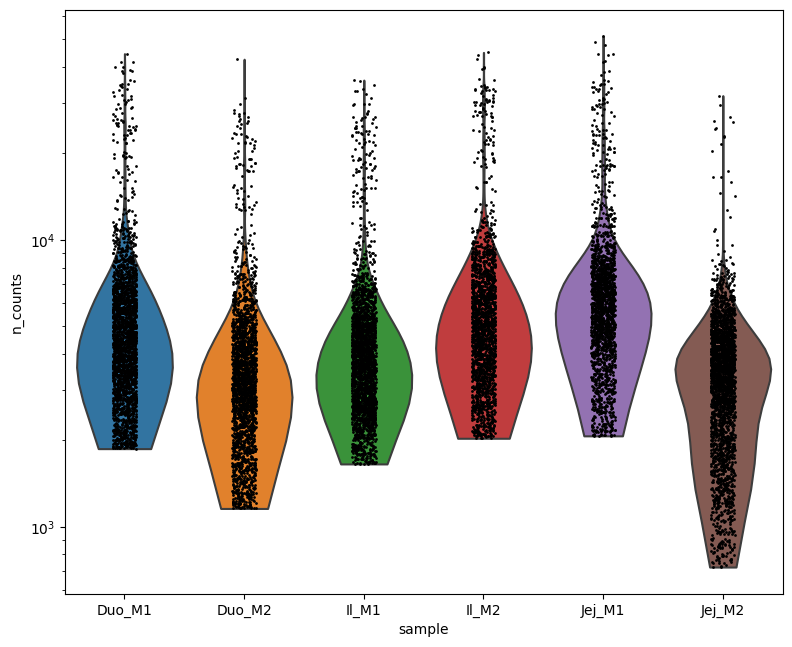

In [15]:
# plot QC metrics

t1 = sc.pl.violin(adata, 'n_counts', groupby= 'sample', size = 2, log = True,
                 cut = 0)


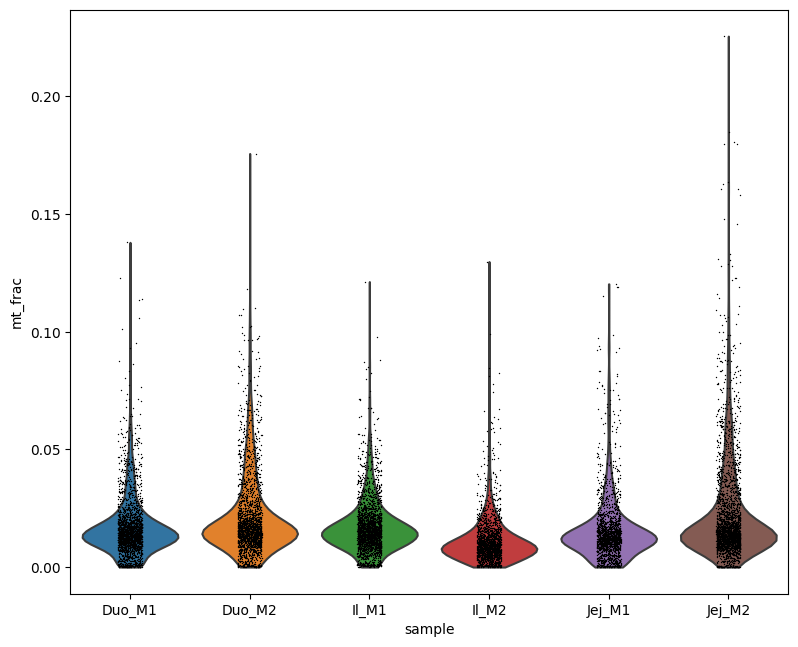

In [16]:
t2 = sc.pl.violin(adata, 'mt_frac', groupby = 'sample')

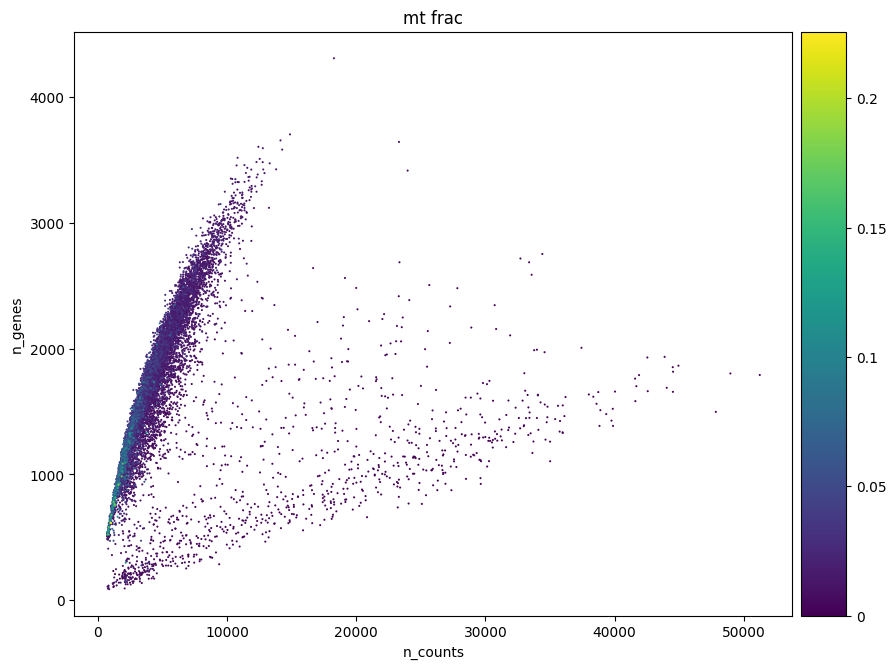

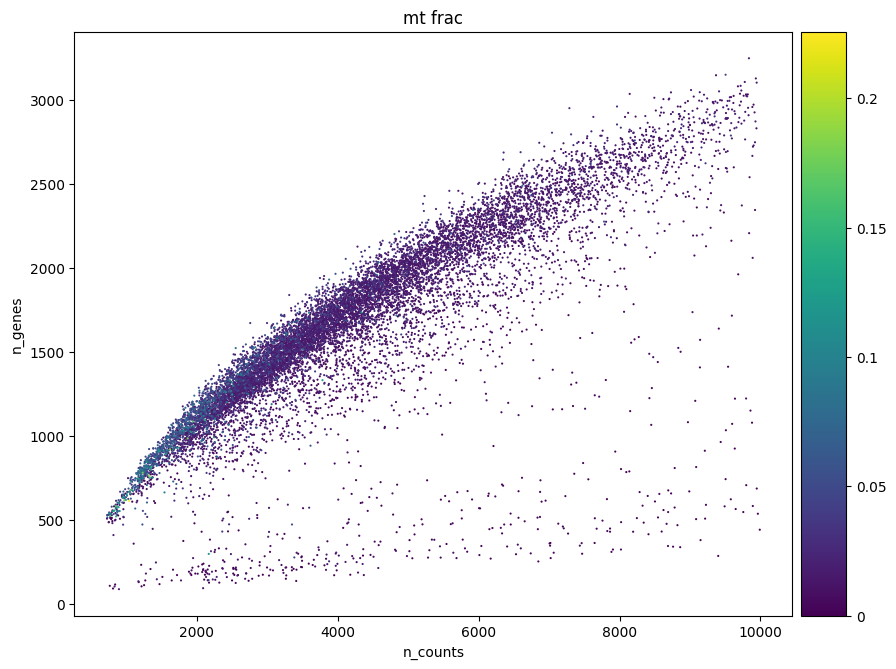

In [17]:
p1 = sc.pl.scatter(adata, 'n_counts','n_genes', color = 'mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], 'n_counts','n_genes', color = 'mt_frac')

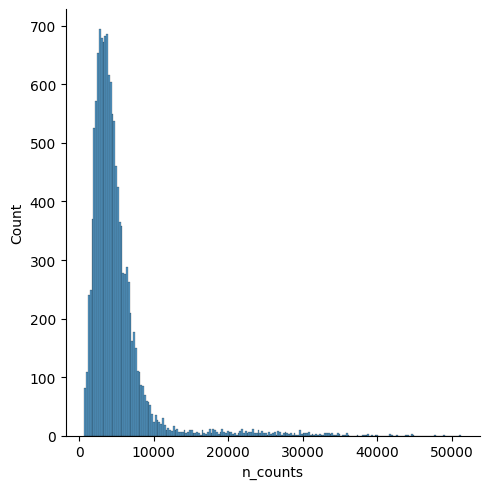

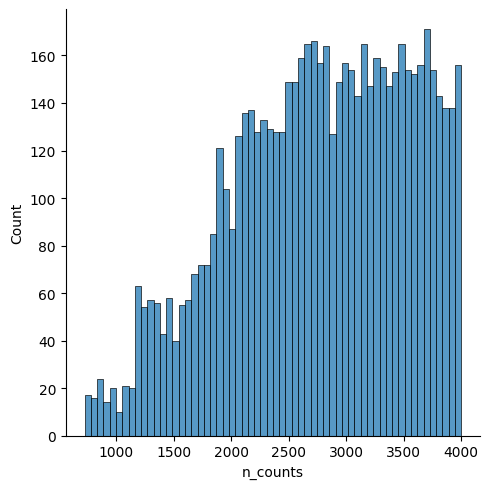

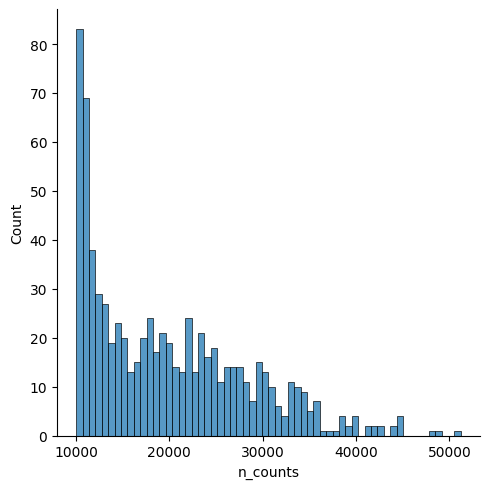

In [18]:
p3 = sb.displot(adata.obs['n_counts'], kde=False)

p4 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde = False, bins =60)

p5 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde = False, bins = 60)


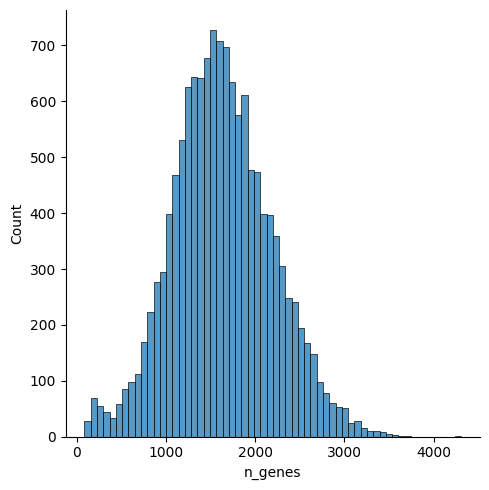

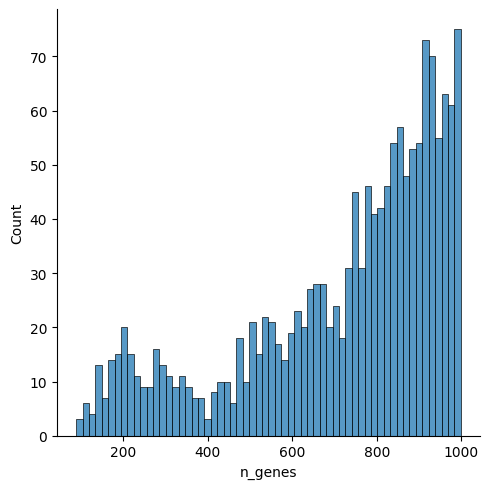

In [19]:
p6 = sb.displot(adata.obs['n_genes'], kde = False, bins = 60)

p7 = sb.displot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde = False, bins = 60)

In [20]:
# filter cells
sc.pp.filter_cells(adata, min_counts = 1500)
sc.pp.filter_cells(adata, max_counts = 40000)
sc.pp.filter_cells(adata, min_genes = 700)
adata = adata[adata.obs['mt_frac']<0.2]

# filter genes
sc.pp.filter_genes(adata, min_cells = 20)


filtered out 479 cells that have less than 1500 counts
filtered out 16 cells that have more than 40000 counts
filtered out 401 cells that have less than 700 genes expressed
filtered out 15180 genes that are detected in less than 20 cells


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [21]:
adata.X

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 2., 0., ..., 2., 0., 0.],
       [2., 0., 0., ..., 1., 0., 0.],
       ...,
       [5., 2., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
# Keep count data in counts layer
adata.layers["counts"] = adata.X.copy()

#normalization
sc.pp.normalize_total(adata, target_sum= 1e4)

#logrithmize
sc.pp.log1p(adata)


normalizing counts per cell
    finished (0:00:00)


In [23]:
adata.raw = adata

In [24]:
# batch correction
sc.pp.combat(adata, key = 'sample')

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



In [25]:
# find HVG
sc.pp.highly_variable_genes(adata, flavor = 'cell_ranger', n_top_genes = 4000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


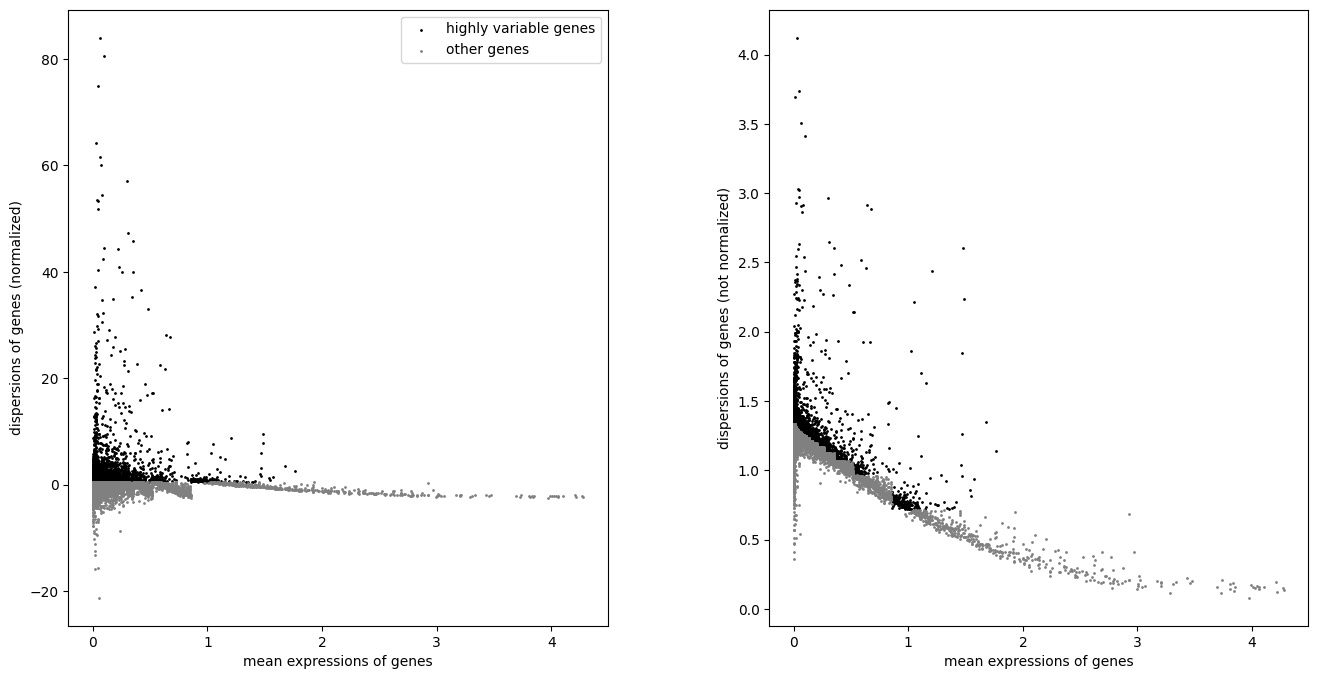

In [26]:
sc.pl.highly_variable_genes(adata)

In [27]:
# visualization

In [28]:
# dimention reduction
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:15)


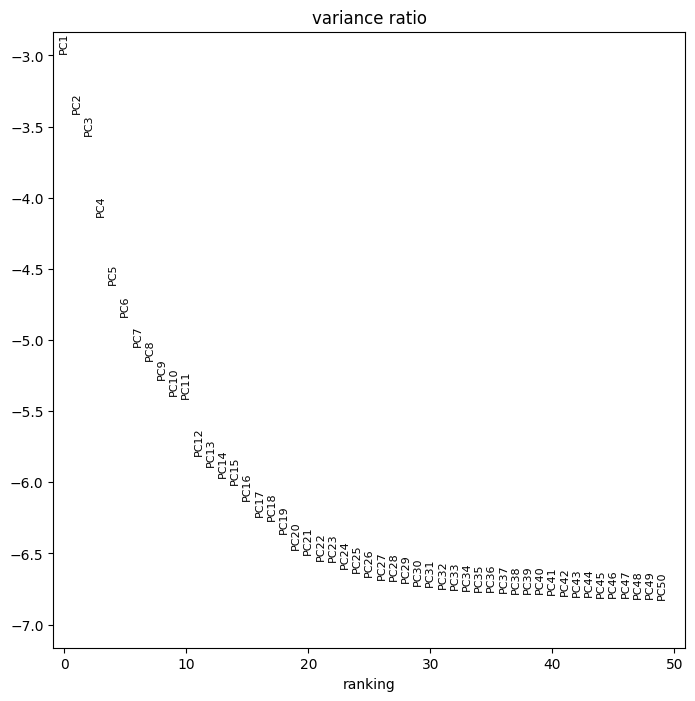

In [29]:
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

In [30]:
# non-linear dimention reduction
sc.pp.neighbors(adata, n_pcs = 40)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


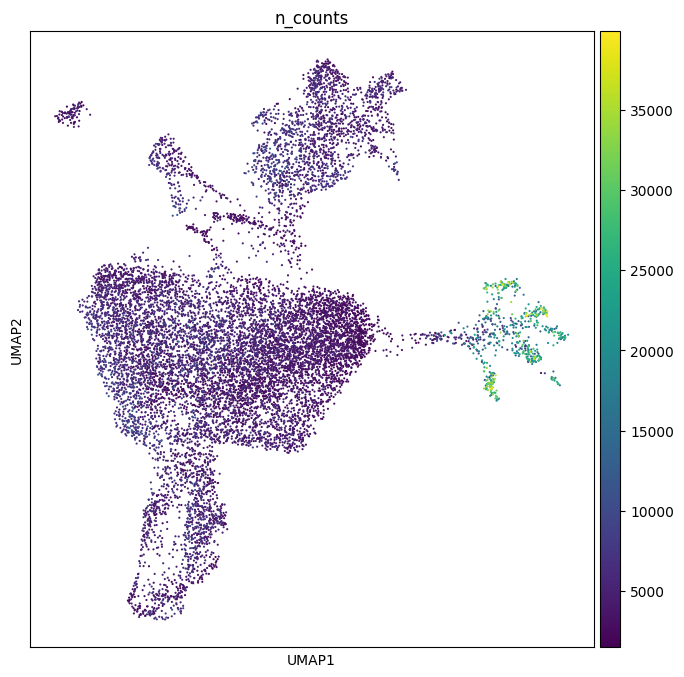

In [31]:
sc.pl.umap(adata, color = "n_counts")


In [32]:
# clusting
sc.tl.louvain(adata, key_added = 'lv_r1')
sc.tl.louvain(adata, resolution = 0.5, key_added = 'lv_r0.5',)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'lv_r1', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'lv_r0.5', the cluster labels (adata.obs, categorical) (0:00:02)


In [33]:
adata.obs['lv_r0.5'].value_counts()

0    4393
1    2899
2    1775
3    1355
4     830
5     667
6     287
7     251
Name: lv_r0.5, dtype: int64

In [34]:
adata.obs['lv_r1'].value_counts()

0     1655
1     1598
2     1460
3     1406
4     1246
5      886
6      865
7      864
8      802
9      663
10     338
11     312
12     253
13      91
14      18
Name: lv_r1, dtype: int64

In [35]:
sc.tl.leiden(adata, key_added='ld_1')
sc.tl.leiden(adata, key_added = 'ld_0.5', resolution=0.5)

running Leiden clustering
    finished: found 20 clusters and added
    'ld_1', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 9 clusters and added
    'ld_0.5', the cluster labels (adata.obs, categorical) (0:00:01)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


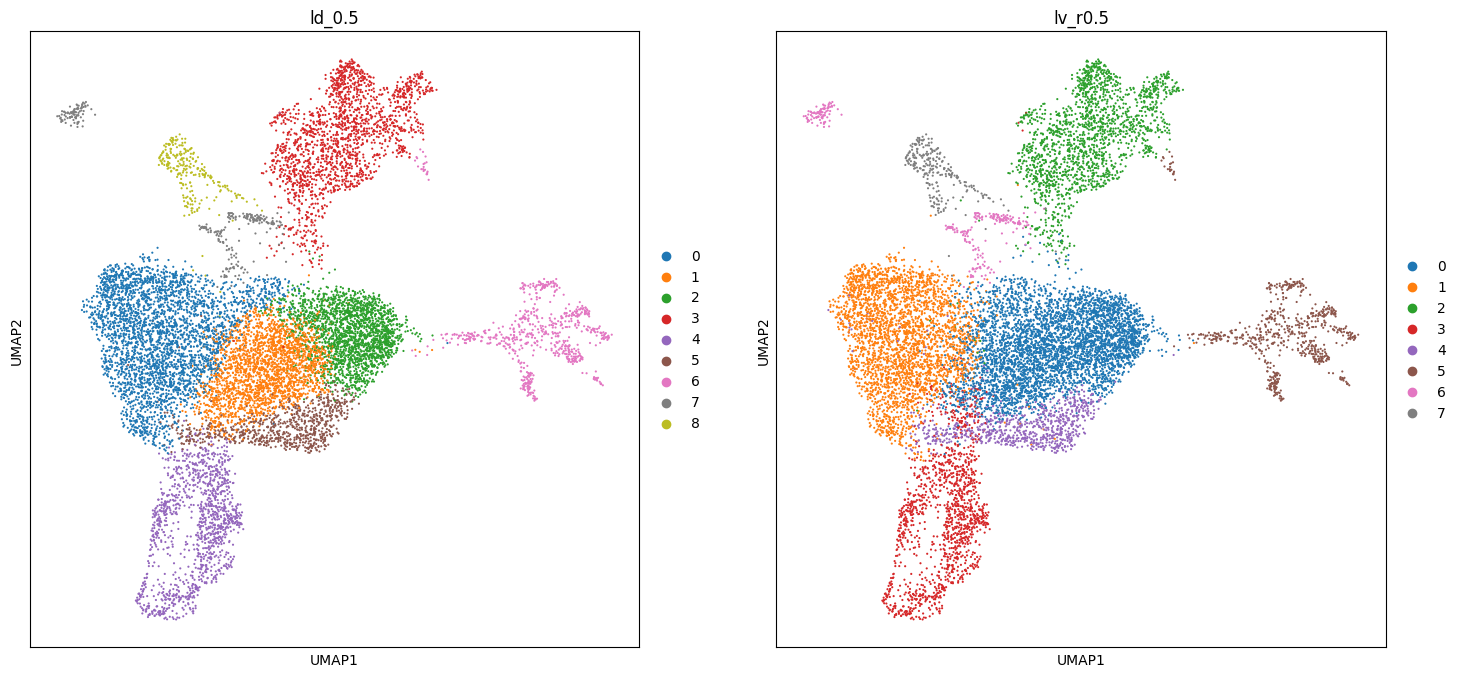

In [36]:
# compare louvain and leiden
sc.pl.umap(adata, color = ['ld_0.5', 'lv_r0.5'])

In [37]:
# calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='lv_r0.5',key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


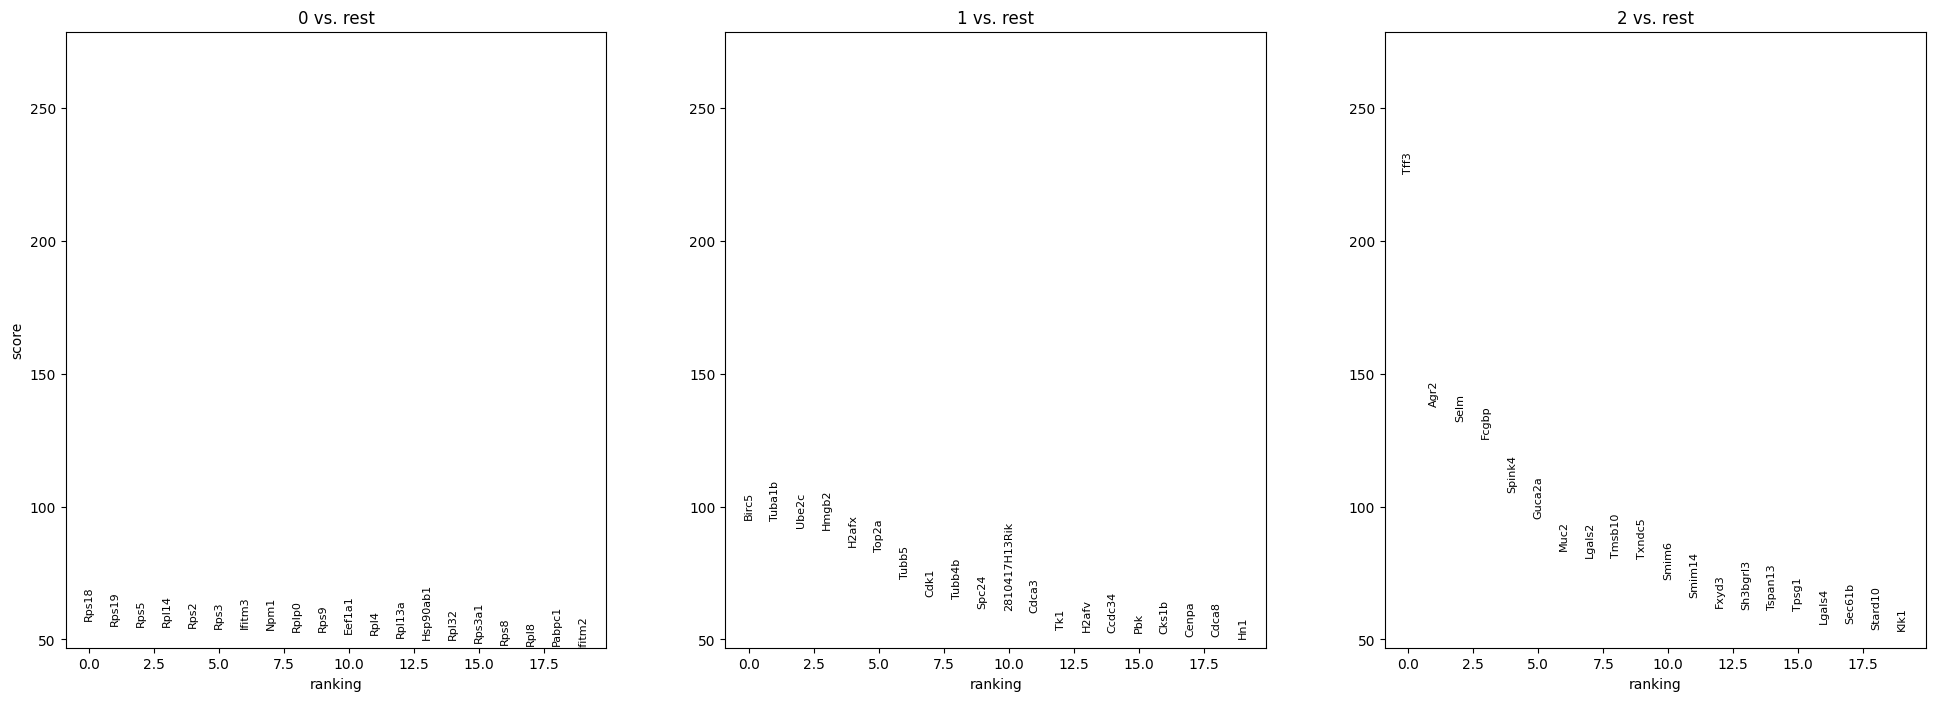

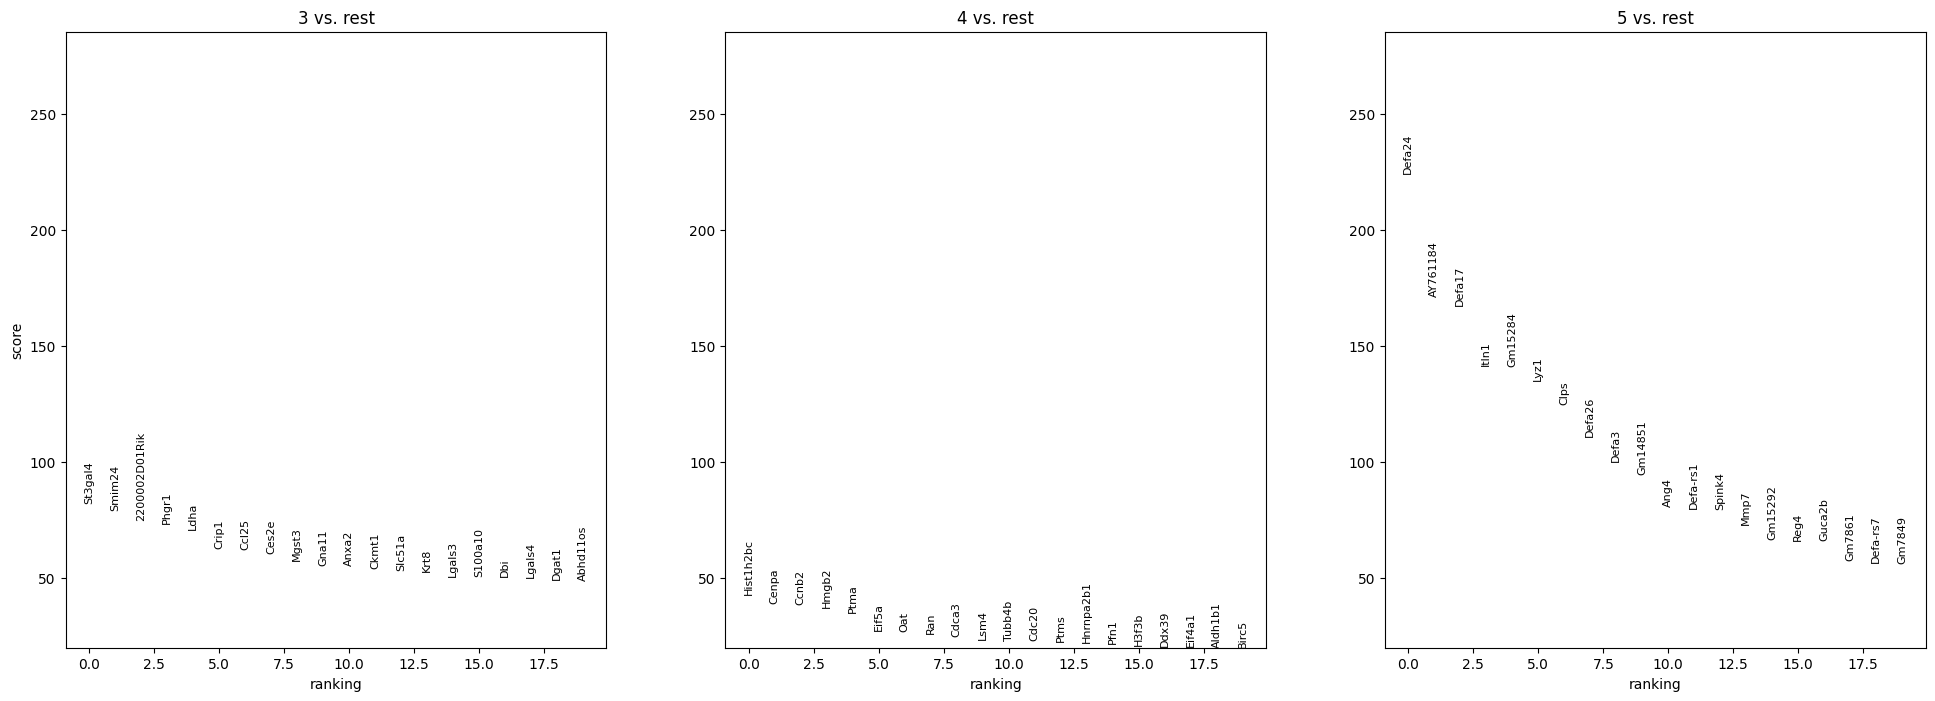

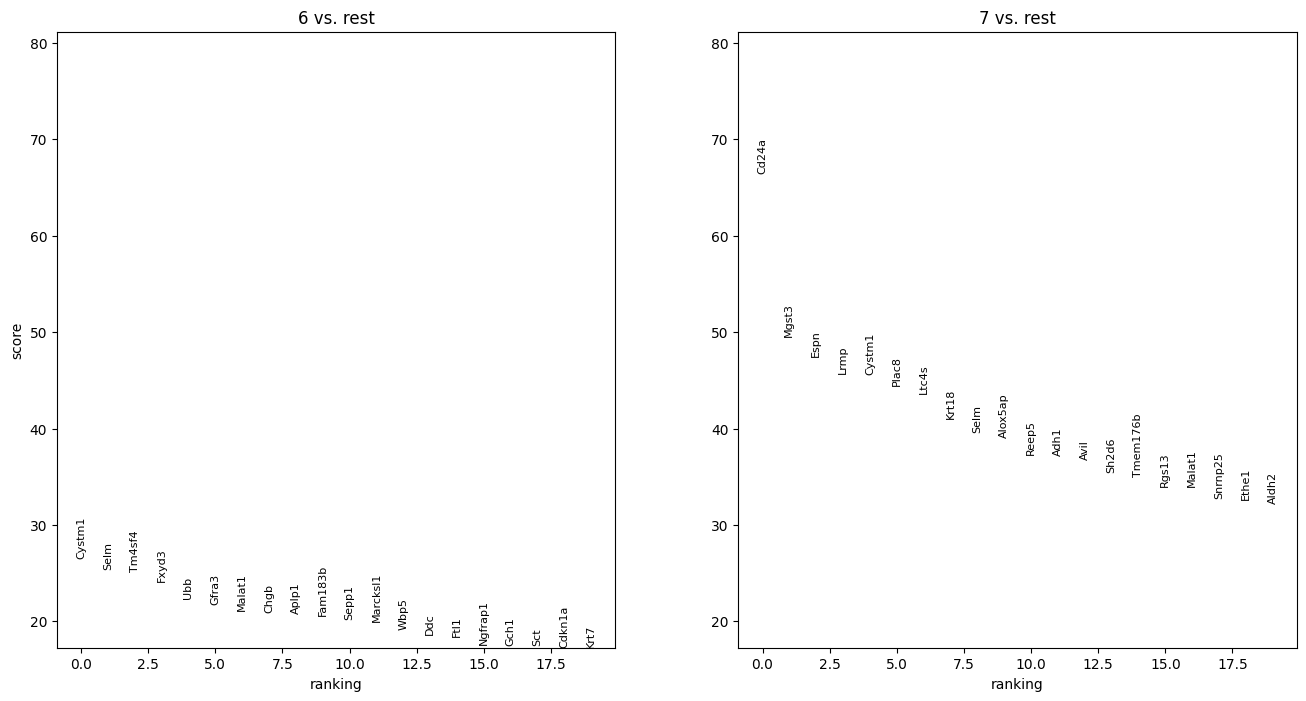

In [38]:
# plot marker genes
sc.pl.rank_genes_groups(adata, key = 'rank_genes_r0.5', groups = ['0','1','2'])
sc.pl.rank_genes_groups(adata, key = 'rank_genes_r0.5', groups = ['3','4','5'])
sc.pl.rank_genes_groups(adata, key = 'rank_genes_r0.5', groups = ['6','7'])

In [39]:
#Known marker genes:
marker_genes = dict()
marker_genes['Stem'] = ['Lgr5', 'Ascl2', 'Slc12a2', 'Axin2', 'Olfm4', 'Gkn3']
marker_genes['Enterocyte (Proximal)'] = ['Gsta1','Rbp2','Adh6a','Apoa4','Reg3a','Creb3l3','Cyp3a13','Cyp2d26','Ms4a10','Ace','Aldh1a1','Rdh7','H2-Q2', 'Hsd17b6','Gstm3','Gda','Apoc3','Gpd1','Fabp1','Slc5a1','Mme','Cox7a1','Gsta4','Lct','Khk','Mttp','Xdh','Sult1b1', 'Treh','Lpgat1','Dhrs1','Cyp2c66','Ephx2','Cyp2c65','Cyp3a25','Slc2a2','Ugdh','Gstm6','Retsat','Ppap2a','Acsl5', 'Cyb5r3','Cyb5b','Ckmt1','Aldob','Ckb','Scp2','Prap1']
marker_genes['Enterocyte (Distal)'] = ['Tmigd1','Fabp6','Slc51b','Slc51a','Mep1a','Fam151a','Naaladl1','Slc34a2','Plb1','Nudt4','Dpep1','Pmp22','Xpnpep2','Muc3','Neu1','Clec2h','Phgr1','2200002D01Rik','Prss30','Cubn','Plec','Fgf15','Crip1','Krt20','Dhcr24','Myo15b','Amn','Enpep','Anpep','Slc7a9','Ocm','Anxa2','Aoc1','Ceacam20','Arf6','Abcb1a','Xpnpep1','Vnn1','Cndp2','Nostrin','Slc13a1','Aspa','Maf','Myh14']
marker_genes['Goblet'] = ['Agr2', 'Fcgbp', 'Tff3', 'Clca1', 'Zg16', 'Tpsg1', 'Muc2', 'Galnt12', 'Atoh1', 'Rep15', 'S100a6', 'Pdia5', 'Klk1', 'Pla2g10', 'Spdef', 'Lrrc26', 'Ccl9', 'Bace2', 'Bcas1', 'Slc12a8', 'Smim14', 'Tspan13', 'Txndc5', 'Creb3l4', 'C1galt1c1', 'Creb3l1', 'Qsox1', 'Guca2a', 'Scin', 'Ern2', 'AW112010', 'Fkbp11', 'Capn9', 'Stard3nl', 'Slc50a1', 'Sdf2l1', 'Hgfa', 'Galnt7', 'Hpd', 'Ttc39a', 'Tmed3', 'Pdia6', 'Uap1', 'Gcnt3', 'Tnfaip8', 'Dnajc10', 'Ergic1', 'Tsta3', 'Kdelr3', 'Foxa3', 'Tpd52', 'Tmed9', 'Spink4', 'Nans', 'Cmtm7', 'Creld2', 'Tm9sf3', 'Wars', 'Smim6', 'Manf', 'Oit1', 'Tram1', 'Kdelr2', 'Xbp1', 'Serp1', 'Vimp', 'Guk1', 'Sh3bgrl3', 'Cmpk1', 'Tmsb10', 'Dap', 'Ostc', 'Ssr4', 'Sec61b', 'Pdia3', 'Gale', 'Klf4', 'Krtcap2', 'Arf4', 'Sep15', 'Ssr2', 'Ramp1', 'Calr', 'Ddost']
marker_genes['Paneth'] = ['Gm15284', 'AY761184', 'Defa17', 'Gm14851', 'Defa22', 'Defa-rs1', 'Defa3', 'Defa24', 'Defa26', 'Defa21', 'Lyz1', 'Gm15292', 'Mptx2', 'Ang4']
marker_genes['Enteroendocrine'] = ['Chgb', 'Gfra3', 'Cck', 'Vwa5b2', 'Neurod1', 'Fev', 'Aplp1', 'Scgn', 'Neurog3', 'Resp18', 'Trp53i11', 'Bex2', 'Rph3al', 'Scg5', 'Pcsk1', 'Isl1', 'Maged1', 'Fabp5', 'Celf3', 'Pcsk1n', 'Fam183b', 'Prnp', 'Tac1', 'Gpx3', 'Cplx2', 'Nkx2-2', 'Olfm1', 'Vim', 'Rimbp2', 'Anxa6', 'Scg3', 'Ngfrap1', 'Insm1', 'Gng4', 'Pax6', 'Cnot6l', 'Cacna2d1', 'Tox3', 'Slc39a2', 'Riiad1']
marker_genes['Tuft'] = ['Alox5ap', 'Lrmp', 'Hck', 'Avil', 'Rgs13', 'Ltc4s', 'Trpm5', 'Dclk1', 'Spib', 'Fyb', 'Ptpn6', 'Matk', 'Snrnp25', 'Sh2d7', 'Ly6g6f', 'Kctd12', '1810046K07Rik', 'Hpgds', 'Tuba1a', 'Pik3r5', 'Vav1', 'Tspan6', 'Skap2', 'Pygl', 'Ccdc109b', 'Ccdc28b', 'Plcg2', 'Ly6g6d', 'Alox5', 'Pou2f3', 'Gng13', 'Bmx', 'Ptpn18', 'Nebl', 'Limd2', 'Pea15a', 'Tmem176a', 'Smpx', 'Itpr2', 'Il13ra1', 'Siglecf', 'Ffar3', 'Rac2', 'Hmx2', 'Bpgm', 'Inpp5j', 'Ptgs1', 'Aldh2', 'Pik3cg', 'Cd24a', 'Ethe1', 'Inpp5d', 'Krt23', 'Gprc5c', 'Reep5', 'Csk', 'Bcl2l14', 'Tmem141', 'Coprs', 'Tmem176b', '1110007C09Rik', 'Ildr1', 'Galk1', 'Zfp428', 'Rgs2', 'Inpp5b', 'Gnai2', 'Pla2g4a', 'Acot7', 'Rbm38', 'Gga2', 'Myo1b', 'Adh1', 'Bub3', 'Sec14l1', 'Asah1', 'Ppp3ca', 'Agt', 'Gimap1', 'Krt18', 'Pim3', '2210016L21Rik', 'Tmem9', 'Lima1', 'Fam221a', 'Nt5c3', 'Atp2a3', 'Mlip', 'Vdac3', 'Ccdc23', 'Tmem45b', 'Cd47', 'Lect2', 'Pla2g16', 'Mocs2', 'Arpc5', 'Ndufaf3']

In [40]:
# annotation
cell_annotation = sc.tl.marker_gene_overlap(adata,marker_genes, key = 'rank_genes_r0.5')

In [41]:
cell_annotation

,0,1,2,3,4,5,6,7
Stem,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Enterocyte (Proximal),0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0
Enterocyte (Distal),0.0,0.0,2.0,17.0,0.0,0.0,0.0,0.0
Goblet,0.0,0.0,63.0,0.0,0.0,13.0,2.0,1.0
Paneth,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0
Enteroendocrine,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0
Tuft,0.0,1.0,2.0,0.0,0.0,3.0,2.0,65.0


<Axes: >

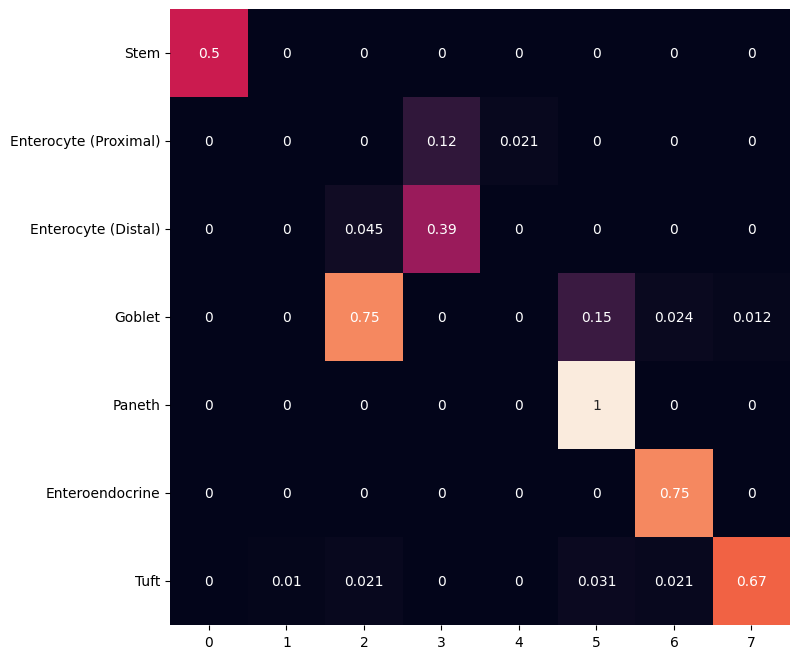

In [42]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key = 'rank_genes_r0.5',
                                                normalize = 'reference')
sb.heatmap(cell_annotation_norm,cbar = False, annot = True)

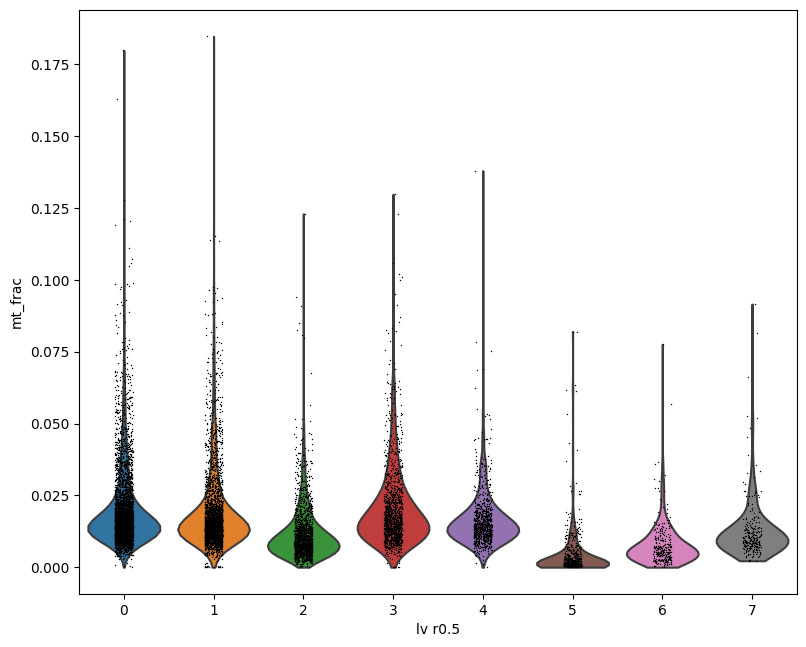

In [43]:


# From the heatmap, cluster 4 express marker genes of Enterocyte(Proximal), they could be another subclusters of enterocyte

# Check the mt-frac
sc.pl.violin(adata,'mt_frac', groupby = 'lv_r0.5')

# Here cluster 4 have no signiture 


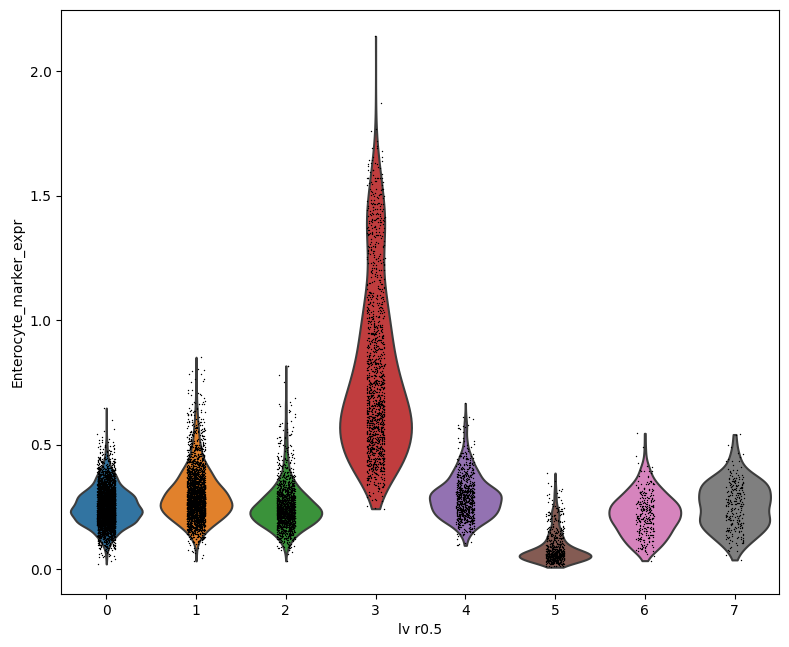

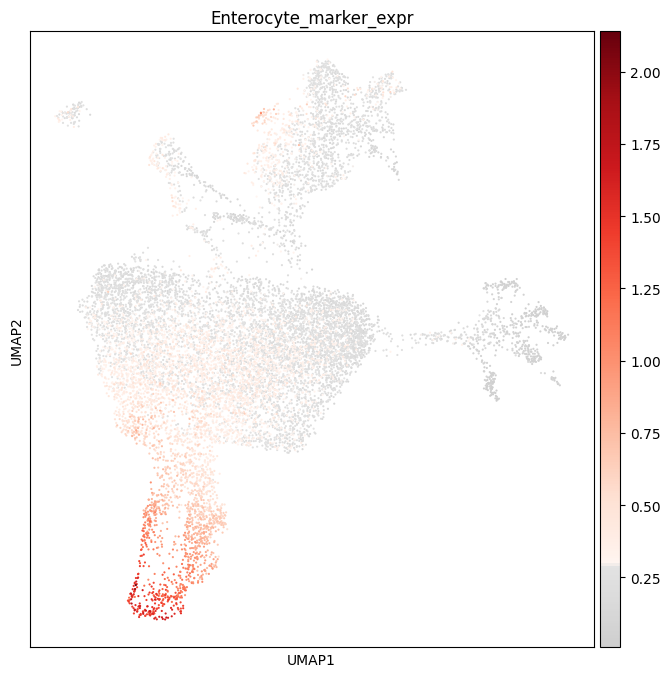

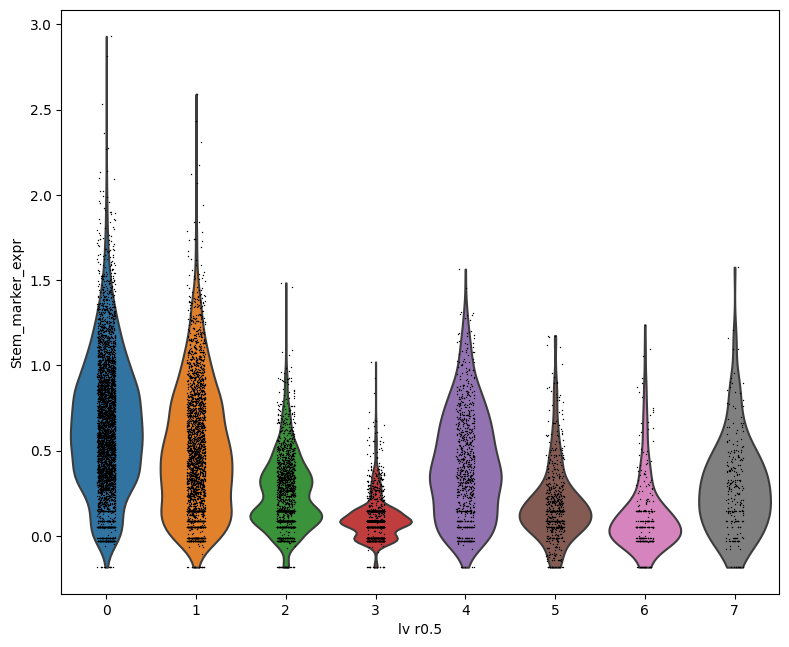

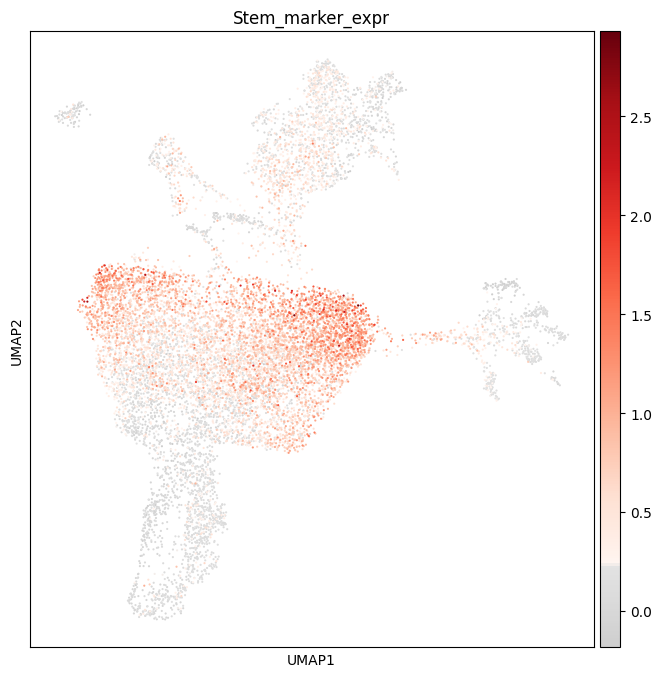

In [44]:
# Here cluster 1,4 have no marker genes, but they are close to cluster 2 (stem cell) and 4(enterocyte) on umap

# check the enterocyte and stem marker genes expression

#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# collate all enterocyte markers
ids_entprox = np.in1d(adata.var_names, marker_genes['Enterocyte (Proximal)'])
ids_entdist = np.in1d(adata.var_names, marker_genes['Enterocyte (Distal)'])
ids_ent = np.logical_or(ids_entprox, ids_entdist)

# calculate mean expression and plot
adata.obs['Enterocyte_marker_expr'] = adata.X[:,ids_ent].mean(1)
sc.pl.violin(adata, 'Enterocyte_marker_expr', groupby='lv_r0.5')
sc.pl.umap(adata, color='Enterocyte_marker_expr', color_map = mymap)

# for stem cell
stem_genes = np.in1d(adata.var_names, marker_genes['Stem'])
adata.obs['Stem_marker_expr'] = adata.X[:,stem_genes].mean(1)


sc.pl.violin(adata, 'Stem_marker_expr', groupby='lv_r0.5')
sc.pl.umap(adata, color = 'Stem_marker_expr', color_map = mymap)


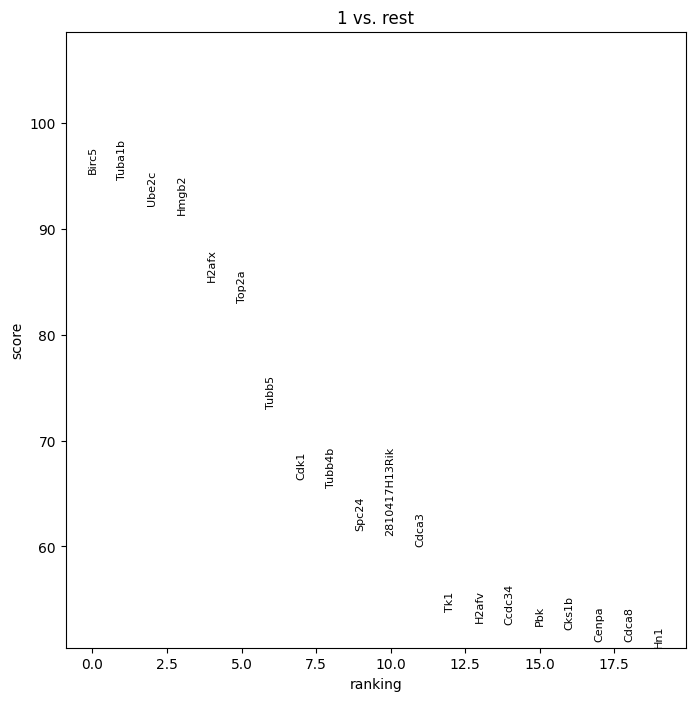

In [45]:
sc.pl.rank_genes_groups(adata, key = 'rank_genes_r0.5', groups = '1')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


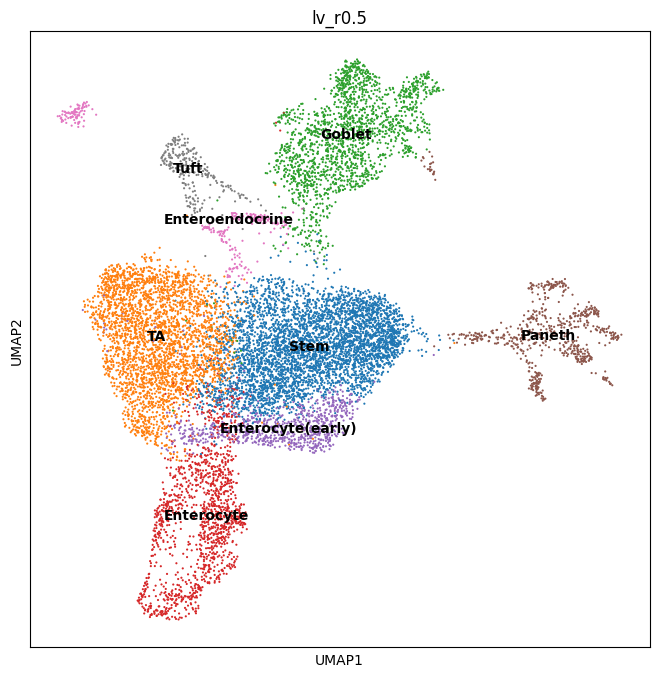

In [46]:
# From (J. M. Li et al., 2021), UBE2C can be marker of transit-amplifying cells. So annotate cluster 1 as TA.

# Cluster 4 shows express pattern like both stem and enterocyte, temporarily annotate cluster 5 as early enterocytes.

# Add annotation
adata.rename_categories('lv_r0.5',['Stem','TA','Goblet','Enterocyte','Enterocyte(early)','Paneth','Enteroendocrine','Tuft'])

# replot the cluster in umap
sc.pl.umap(adata, color = 'lv_r0.5', legend_loc = 'on data')

In [47]:
#Subsetting to relevant clusters
clusters_to_include = [g for g in adata.obs['lv_r0.5'].cat.categories if (g.startswith('Enterocyte') or g.startswith('TA') or g.startswith('Stem'))]
adata_ent = adata[np.isin(adata.obs['lv_r0.5'], clusters_to_include),:].copy()

#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent, flavor='cell_ranger', n_top_genes=4000, subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)


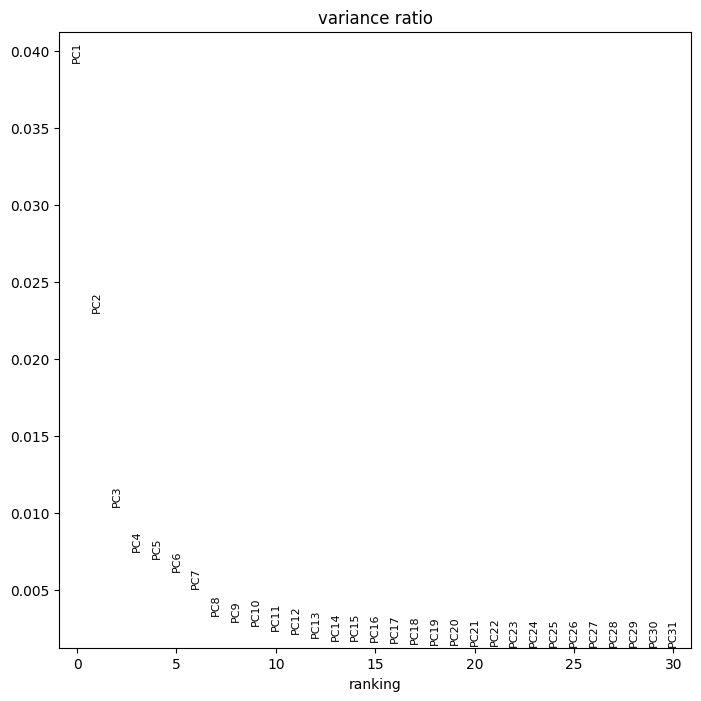

In [48]:
# recalculate PCA for subset
sc.pp.pca(adata_ent, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata_ent)

In [49]:
# choose first 7 PC
adata_ent.obsm['X_pca'] = adata_ent.obsm['X_pca'][:,0:7]

In [53]:
# preprocessing for monocle

data_mat_mon = adata.layers['counts'].T
var_mon = adata.var.copy()
obs_mon = adata.obs.copy()



In [58]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, Enterocytes(early), TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$lv_r0.5)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("Stem", "Enterocyte(early)", "TA", "Enterocyte")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$lv_r0.5)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

[1] "Number of cells after filtering:"
[1] 9477
[1] ""


Removing 29 outliers
此外: There were 11 warnings (use warnings() to see them)


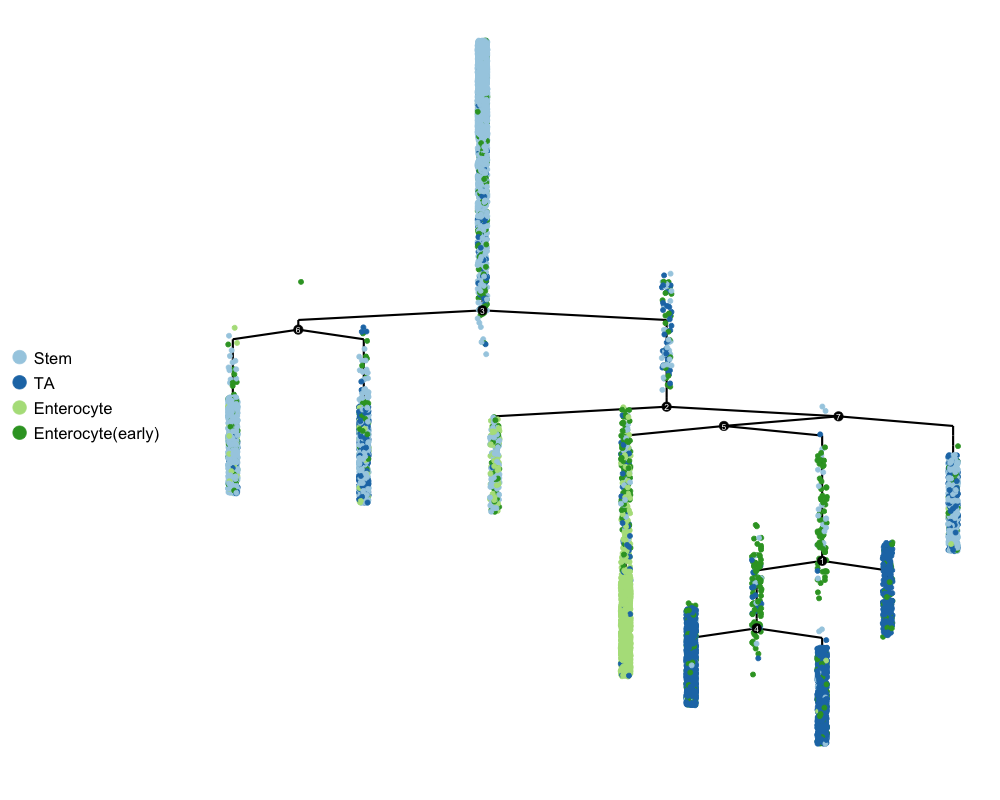

In [59]:
%%R -w 1000 -h 800

#Get a nice colour map
custom_colour_map = brewer.pal(length(unique(pData(ie_regions_cds)$lv_r0.5)),'Paired')

#Find the correct root state that coresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$lv_r0.5)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

# Visualize with cluster labels
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(ie_regions_cds, color_by = 'lv_r0.5', show_branch_points = T, 
                             cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
scale_size(range = c(0.2, 0.2)) +
theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
guides(colour = guide_legend(override.aes = list(size=6))) + 
scale_color_manual(values = custom_colour_map)

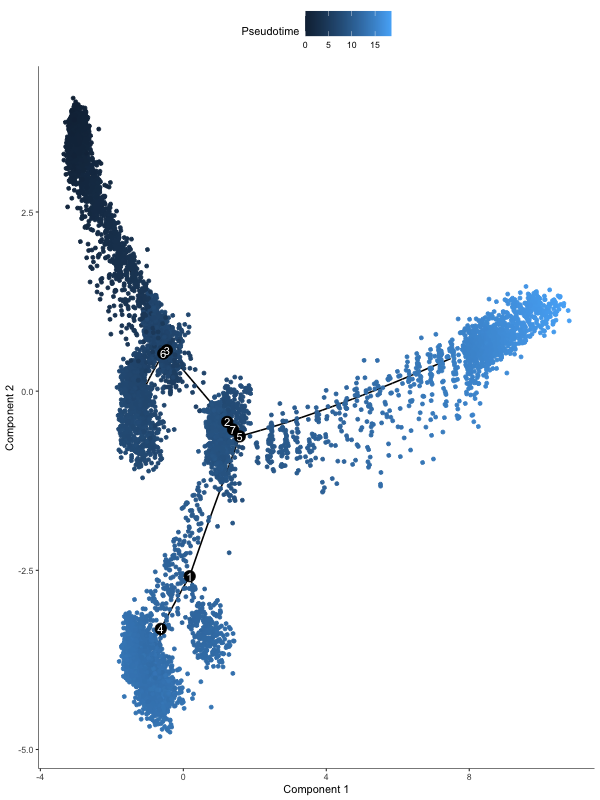

In [60]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
plot_cell_trajectory(ie_regions_cds, color_by="Pseudotime")